In [1]:
import sys,os 
sys.path.append('/home/benr/ACT/CW2/py')
import numpy as np 


import pandas as pd 
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from functions import get_data,split_data_torch,evaluate,plot_train
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

2025-12-12 17:12:16.918615: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 17:12:17.300506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 17:12:18.625842: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#Ensure CUDA is available. 
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

CUDA available: True
CUDA version: 12.8
CUDA_VISIBLE_DEVICES: None


# Question 3, Using Data Augmentation to improve a CNN 

In this Notebook we will explore how image roatation and normalising image data can imporve the Convolutional neural network we created in Q2. 

In [3]:
# get the data from functions.py
images,labels = get_data()
# convert images to pytorch tnesors
images = torch.from_numpy(images)
labels = torch.from_numpy(labels).long()

print(images.shape)


/home/benr/.astroNN/datasets/Galaxy10_DECals.h5 was found!
torch.Size([17736, 256, 256, 3])


In [4]:
# Move channels: (N,H,W,C) -> (N,C,H,W)
images = images.permute(0, 3, 1, 2)      
# standardise 
images = images.float() / 255.0    
# The mean and standard deviation will be used later for normalisation   
mean = images.mean(dim=[0,2,3])
std = images.std(dim=[0,2,3])
print(images.shape)
print(mean)
print(std)

torch.Size([17736, 3, 256, 256])
tensor([0.1675, 0.1626, 0.1589])
tensor([0.1287, 0.1180, 0.1116])


In [ ]:
class Galaxy_CNN(nn.Module):
    def __init__(self, inCH, nCL):  
        super(Galaxy_CNN, self).__init__()
        # conv blocks
        self.conv1 = nn.Conv2d(3, inCH, kernel_size=7, stride=1, padding=4)
        # batchnorm is a way of normalising the activation values
        self.bn1   = nn.BatchNorm2d(inCH)

        self.conv2 = nn.Conv2d(inCH, inCH*2, kernel_size=5, stride=2, padding=1)
        self.bn2   = nn.BatchNorm2d(inCH*2)

        self.conv3 = nn.Conv2d(inCH*2, inCH, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(inCH)

        self.pool = nn.MaxPool2d(2, 2)
        #dropout is a way of 'turning off' some nodes temporarily, to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        #Adaptive pooling layer to reduce to a specific size
        self.gap = nn.AdaptiveAvgPool2d(2)
        # fully connected final layer 
        self.lin = nn.Linear(inCH*4, nCL)

    def forward(self, x):
        # The forward section passes the batch through the graph
        x = self.pool(F.relu(self.bn1(self.conv1(x))))# conv1 -> batchnorm -> relu -> pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))# conv2 -> batchnorm -> relu -> pooling 
        x = self.pool(F.relu(self.bn3(self.conv3(x))))# conv3 -> batchnorm -> relu -> pooling
        x = self.gap(x)
        #change shpae of tensor for linear layer (batch size,total features)    
        x = x.view(x.size(0), -1)    
        x = self.dropout(x) 
        x = self.lin(x)
        return x

The kinds of data agumentation we want to implement take place in the training function, so for this question we will define the training function in this notebook rather than in functions.py, 

Since the evaluate() function is unchanged this will still be called from functions.py

This code block also includes the random_rotate function, this function will implement a rotatrion on a certrain percentage of the image chosen by the user. The function carries out rotations of $90^o$, $180^o$ or $270^o$.

In [ ]:
# function to rotate half of the images
def random_rotate(imgs,p,degs):
   # only rotate images half of the time 
   S = imgs.size(0)
   for i in range(S):
     if torch.rand(1).item() > p: 
      angle = torch.empty(1).uniform_(-degs,degs).item()
      # rotate image between -180-180 degrees 
      imgs[i] = TF.rotate(imgs[i],angle=angle,interpolation=InterpolationMode.BILINEAR,
                       expand=False) 
   return imgs  
#flip half of the images horizontally 
def random_hflip(imgs,p):
  S = imgs.size(0)
  for i in range(S):
    if torch.rand(1).item() < p:
      imgs[i] = TF.hflip(imgs[i])
  return imgs 
#flip half of the images vertically 
def random_vflip(imgs,p):
  S = imgs.size(0)
  for i in range(S):
    if torch.rand(1).item() < p:
      imgs[i] = TF.vflip(imgs[i])
  return imgs 
# function to implement all three augmentation methods 
def augment(imgs,degs,p):
  imgs = random_rotate(imgs,degs,p)
  imgs = random_vflip(imgs,p)
  imgs = random_hflip(imgs,p) 
  return imgs 

def train(model,trainLoader,testLoader,mean_tensor,std_tensor,criterion,optimizer
          ,scheduler,device,n_epoch):
  early_stop = 10 
  stop = 0
  best_acc = 0.0 
  trn_accs = []
  tst_accs = []
  for e in range(n_epoch):
    #use model in training mode 
    model.train()
    #increment loss for each image 
    running_loss = 0.0
    # number of correct labels
    correct = 0
    # total number of samples 
    total = 0


    for imgs,lbl in trainLoader:
      # move image to GPU
      imgs = imgs.to(device)
      imgs = (imgs - mean_tensor) / std_tensor 
      #Augment images
      imgs = augment(imgs,180,0.5)
      #move label to GPU 
      labels = lbl.to(device)
      #clear old gradients 
      optimizer.zero_grad()
      # predict labels 
      outputs = model(imgs)
      # workout the loss for the prediction 
      loss = criterion(outputs,labels)
      # use backpropagation to calculate new weights 
      loss.backward()
      # update weights 
      optimizer.step()
      # get batch loss 
      running_loss += loss.item() * imgs.size(0)
      # return position of most likely catagory for each image in batch 
      _,preds = torch.max(outputs,1)
      # count the correctly predicted samples 
      correct += (preds == labels).sum().item()
      # increae the total samples 
      total += labels.size(0)
    # calculate train_loss for epoch 
    trn_loss = running_loss / total
    scheduler.step(trn_loss)
    # calculate train accuracy 
    trn_acc = correct / total 
    trn_accs.append(trn_acc)
    # test trained model 
    test_acc = evaluate(model, testLoader,mean_tensor, std_tensor, device)
    tst_accs.append(test_acc)
    if test_acc > best_acc:
       best_acc = test_acc
       torch.save(model.state_dict(), "best_model_q3.pt")
       print(f"Saved new best model (acc={best_acc:.4f})")
       stop = 0 
    else:
       stop += 1 
    if stop == early_stop:
      plot_train(e,trn_accs,tst_accs)
      break 
    print(f"Epoch {e+1}/{n_epoch} "
        f"Train loss: {trn_loss:.4f}  "
        f"Train acc: {trn_acc:.3f}  "
        f"Test acc: {test_acc:.3f}")
  if stop < early_stop:
   plot_train(e,trn_accs,tst_accs) 

In [7]:
#split tensor into training and test sets (see functions.py)
I = np.arange(len(labels))
xtrn,xtst,ytrn,ytst = split_data_torch(images,labels,I)


# match images and labels in a torch dataset 
train_ds = TensorDataset(xtrn, ytrn)
test_ds  = TensorDataset(xtst, ytst)



#create train and test loaders for training
train_loader = DataLoader(
    train_ds, batch_size=6, shuffle=True,
    num_workers=4, pin_memory=True
)

test_loader  = DataLoader(
    test_ds, batch_size=6, shuffle=False,
    num_workers=4, pin_memory=True
)


In [ ]:
# number of catagories 
num_classes = len(labels.unique())
# tell the computer to use the GPU via CUDA 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#The network model 
model = Galaxy_CNN(128,num_classes).to(device)
''' The criterion is the loss function, in this case we are using cross entropy. 
This function asigns probabilities to each catagory, for example [0,1,0,0...] might be
a spiral galaxy. Cross entropy then measures how close the outputs are to this true 
probability.'''
criterion = nn.CrossEntropyLoss()
# the method of gradient decent used in backpropogation. 
optimizer = torch.optim.Adam(model.parameters(),lr=10**-3,weight_decay=1e-4)

#for normalisation 
mean_tensor = mean.view(1,3,1,1).to(device)
std_tensor = std.view(1,3,1,1).to(device)

#learning rate scheduler, learning rate decreases by 50% every 15 epochs. 
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.5)


print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))


0
NVIDIA GeForce RTX 4060 Laptop GPU


/home/benr/ACT/CW2/venv1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.


Saved new best model (acc=0.3106)
Epoch 1/70 Train loss: 2.0556  Train acc: 0.239  Test acc: 0.311
Saved new best model (acc=0.3805)
Epoch 2/70 Train loss: 1.9081  Train acc: 0.307  Test acc: 0.380
Saved new best model (acc=0.4656)
Epoch 3/70 Train loss: 1.7222  Train acc: 0.377  Test acc: 0.466
Saved new best model (acc=0.5000)
Epoch 4/70 Train loss: 1.5726  Train acc: 0.426  Test acc: 0.500
Saved new best model (acc=0.5299)
Epoch 5/70 Train loss: 1.4623  Train acc: 0.472  Test acc: 0.530
Saved new best model (acc=0.5992)
Epoch 6/70 Train loss: 1.3607  Train acc: 0.509  Test acc: 0.599
Saved new best model (acc=0.6077)
Epoch 7/70 Train loss: 1.2875  Train acc: 0.544  Test acc: 0.608
Saved new best model (acc=0.6313)
Epoch 8/70 Train loss: 1.2208  Train acc: 0.570  Test acc: 0.631
Saved new best model (acc=0.6618)
Epoch 9/70 Train loss: 1.1670  Train acc: 0.595  Test acc: 0.662
Saved new best model (acc=0.6832)
Epoch 10/70 Train loss: 1.1168  Train acc: 0.615  Test acc: 0.683
Saved new

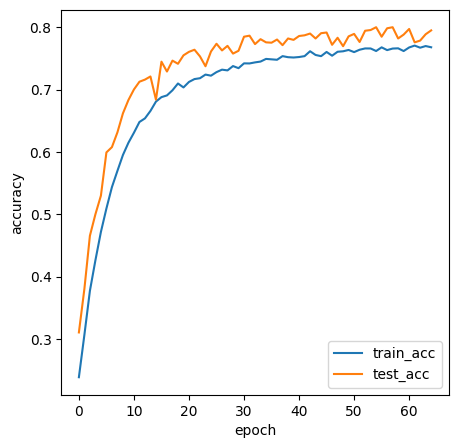

In [9]:
# begin training 
train(model, train_loader,test_loader,  
      mean_tensor,std_tensor,
      criterion, 
      optimizer,scheduler, device, 
      n_epoch=70)


These results are an improvement... 